# Perturbation Response Scanning

## Summary

Proteins are not merely molecules with conformation, but also machines with specific motions that carry out highly complex functions (e.g. catalysis, regulation, etc). A known trait of many proteins is their allosteric mechanisms, in which residues that are placed far away from the active site are able to modify the activity of the active site. Although allostery is an interesting phenomenon with many applications (e.g. development of better catalysts or new drugs), the detection of allosteric mechanisms is not trivial.

Perturbation Response Scanning (*PRS*) is a computational technique that has allowed the study of allosteric mechanisms in different systems (e.g. PDZ domains [[Gerek and Ozkan 2011](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002154)], Ferric Binding Protein[[Atligan and Atligan 2009](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000544)]). While other computational techniques rely in intensive molecular simulations, PRS uses perturbations on coarse-grained anisotropic normal-mode network model of proteins, so calculations can be carried out in a desktop computer. A typical PRS analysis generates an effectiveness-sensitivity asymetric matrix that accounts for the ability of some residues to induce allosteric responses (*effectiveness*) and the response carried out upon perturbation by each residue (*sensitivity*).

The G subunit of the alternative nitrogenases is not in contact with the active site, yet it seems to affect its activity. Nitrogenases display a certain degree of internal mobility through long-distance interactions during their Fe-cycle [[Danyal et al 2016](https://www.pnas.org/doi/full/10.1073/pnas.1613089113)], as it has been recently confirmed by cryo-Electron Microscopy [[Rutledge et al 2022](https://www.science.org/doi/10.1126/science.abq7641)]. Thus, we especulate that the G-subunit might be acting also through non-local interactions with the active sites. We apply PRS and we retrieve some non-trivial end-to-end communications between G-subunits.

In [1]:
import prody as pdy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Methods 

1. Generate Experiment and Control: 5N6Y(DKG/DKG) and 5N6Y(DK/DK).
2. Apply PRS scanning in both of them.
3. Compare profiles of Sensitivity and Effectivity
    1. Plot
    2. Structure

In [2]:
azov_vnf = pdy.parsePDB('../structure/5n6y.pdb').select('protein')
azov_vnf_dkg = azov_vnf.select('name CA')
azov_vnf_dk = azov_vnf.select('name CA and (chain A or chain B or chain D or chain E)')

Calculation. It should take over a minute.

In [3]:
# DKG
anm_azov_vnf_dkg = pdy.ANM('DKG')
anm_azov_vnf_dkg.buildHessian(azov_vnf_dkg)
anm_azov_vnf_dkg.calcModes('all')
prs_mat_dkg, effectiveness_dkg, sensitivity_dkg = pdy.calcPerturbResponse(anm_azov_vnf_dkg)
print("DKG - calculation over")
# DK
anm_azov_vnf_dk = pdy.ANM('DK')
anm_azov_vnf_dk.buildHessian(azov_vnf_dk)
anm_azov_vnf_dk.calcModes('all')
prs_mat_dk, effectiveness_dk, sensitivity_dk = pdy.calcPerturbResponse(anm_azov_vnf_dk)
print("DK - calculation over")

DKG - calculation over
DK - calculation over


## Results

### PRS in *Azotobacter vinelandii* Vnf

In [9]:
azov_vnf_dk_chains = azov_vnf_dk.getChids()
azov_vnf_dkg_chains = azov_vnf_dkg.getChids()
azov_vnf_dk_resnums = azov_vnf_dk.getResnums()
azov_vnf_dkg_resnums = azov_vnf_dkg.getResnums()
azov_vnf_dkg_resnames = azov_vnf_dkg.getResnames()
azov_vnf_dk_resnames = azov_vnf_dk.getResnames()
azov_vnf_dkg_data = pd.DataFrame.from_dict(
    dict(effectivness=effectiveness_dkg, sensitivity=sensitivity_dkg, chain=azov_vnf_dkg_chains, 
         resnum=azov_vnf_dkg_resnums, index=np.arange(len(azov_vnf_dkg_chains)), resname=azov_vnf_dkg_resnames)
)
azov_vnf_dk_data = pd.DataFrame.from_dict(
    dict(effectivness=effectiveness_dk, sensitivity=sensitivity_dk, chain=azov_vnf_dk_chains, 
         resnum=azov_vnf_dk_resnums, index=np.arange(len(azov_vnf_dk_chains)), resname=azov_vnf_dk_resnames)
)

In [21]:
px.scatter(
    azov_vnf_dkg_data, x='sensitivity', y='effectivness', color='chain', hover_data=['chain', 'resnum', 'resname', 'sensitivity'],
    width=450, height=450, template='seaborn'
)

**Figure 1**: Sensitivity versus effectivness. The chains B and E, which represent VnfK subunits, are not affected by perturbations. The chains A and D, repreenting VnfD subunits, have show certain response to perturbation. The chains C and F, representing VnfG subunits, have the most sensible and effective sites. However, the overall magnitudes of these perturbations are small if compared with previous examples from the literature, so we expect only minor re-arrangements rather than global conformational changes induced by allostery.

In [20]:
px.line(
    azov_vnf_dkg_data, x='index', y='sensitivity', color='chain', hover_data=['chain', 'resnum', 'resname', 'sensitivity'],
    width=800, height=450, template='seaborn'
)

**Figure 2**: Residue Index versus Sensitivity. Shows the same information as **Figure 1**.

In [6]:
azov_vnf_diff_data = pd.merge(azov_vnf_dkg_data, azov_vnf_dk_data, on=['chain', 'resum'], how='inner')
azov_vnf_diff_data['diff_effectivness'] = azov_vnf_diff_data['effectivness_x'] - azov_vnf_diff_data['effectivness_y']
azov_vnf_diff_data['diff_sensitivity'] = azov_vnf_diff_data['sensitivity_x'] - azov_vnf_diff_data['sensitivity_y']

Now will represent the difference between the structure with and without the D and G subunits.

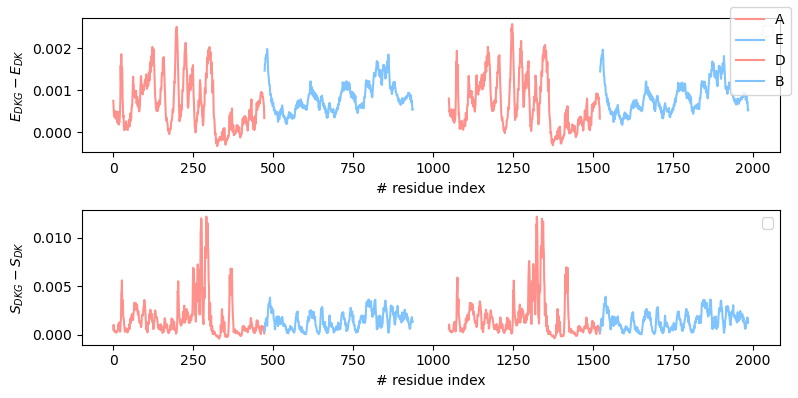

In [23]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(8, 4)
g = sns.lineplot(
    x='index_x', y='diff_sensitivity', data=azov_vnf_diff_data, hue='chain', palette=[r'#FF918C', r'#80C4FF', r'#FF918C', r'#80C4FF'], ax=ax[0],
    legend=False
)
ax[0].set_xlabel('# residue index')
ax[0].set_ylabel(r'$E_{DKG} - E_{DK}$')

g = sns.lineplot(
    x='index_x', y='diff_effectivness', data=azov_vnf_diff_data, hue='chain', palette=[r'#FF918C', r'#80C4FF', r'#FF918C', r'#80C4FF'], ax=ax[1]
)
ax[1].set_xlabel('# residue index')
ax[1].legend([])
ax[0].legend([])
ax[1].set_ylabel(r'$S_{DKG} - S_{DK}$')
fig.legend()
fig.tight_layout()
plt.savefig('../figures/fig_delta_sensitivity.5n6y.png', dpi=300)

**Figure 3**. This figure compares the sensitivity (S) and effectivity (E) changes upon removal of the G subunit. In both cases, it's the D subunit (chains A and D) the most affected one, as we could expect. However, the magnitude of these changes is small, so we might expect re-organization of the protein structure rather than global conformational re-arrangements.

### Structure visualization

The following blocks save the resulting structures with the effectivity and sensitivity stored in the b-factor and occupancy columns of the PDB files, so they can be represented in Chimera, PyMol, VMD, etc.

In [11]:
for residue, e, s in zip(azov_vnf.getHierView().iterResidues(), effectiveness_dkg, sensitivity_dkg):

    residue.setBetas(e * 100)
    residue.setOccupancies(e * 100)

pdy.writePDB('../data/prs/azov_vnf_dkg_all.prs.pdb', azov_vnf)

'../data/prs/azov_vnf_dkg_all.prs.pdb'

In [12]:
azov_vnf_dkg.setBetas(effectiveness_dkg * 100)
azov_vnf_dkg.setOccupancies(sensitivity_dkg * 1000)
azov_vnf_dk.setBetas(effectiveness_dk* 100)
azov_vnf_dk.setOccupancies(sensitivity_dk* 1000)

pdy.writePDB('../data/prs/azov_vnf_dkg.prs.pdb', azov_vnf_dkg)
pdy.writePDB('../data/prs/azov_vnf_dk.prs.pdb', azov_vnf_dk)

azov_vnf_dk.setBetas(azov_vnf_diff_data['diff_effectivness'].values * 100)
azov_vnf_dk.setOccupancies(azov_vnf_diff_data['diff_sensitivity'].values * 1000)

pdy.writePDB('../data/prs/azov_vnf_dk.diffprs.pdb', azov_vnf_dk)

'../data/prs/azov_vnf_dk.diffprs.pdb'

### Peturbation of the Leu 18

It has been observed that the Leu18 is quite a conserved residue interacting with a conserved pocket in the D-interface. We consider the effects of a perturbation induced in this residue across the whole nitrogenase complex.

In [13]:
l18 = pdy.sliceAtomicData(prs_mat_dkg, atoms=azov_vnf_dkg, axis=0, select='chain C and resnum 18')
pdy.writePDB('../data/prs/azov_vnf_dkg.leu18.pdb', azov_vnf_dkg, beta=np.clip(l18[0] , a_min=None, a_max=0.15)* 100)

'../data/prs/azov_vnf_dkg.leu18.pdb'

In [14]:
for residue, s in zip(azov_vnf.getHierView().iterResidues(), np.clip(l18[0] , a_min=None, a_max=0.15)* 100):

    # residue.setBetas(e * 100)
    residue.setOccupancies(s)

pdy.writePDB('../data/prs/azov_vnf_dkg_all.prs.pdb', azov_vnf)

'../data/prs/azov_vnf_dkg_all.prs.pdb'

In [15]:
azov_vnf_dkg_data['leu18'] = np.clip(l18[0], a_max=0.15, a_min=None)

In [16]:
azov_vnf_dkg_data

,effectivness,sensitivity,chain,resum,index,leu18
0,0.002819,0.007552,A,2,0,0.021528
1,0.004721,0.006322,A,3,1,0.016320
2,0.004815,0.005668,A,4,2,0.012351
3,0.002942,0.005904,A,5,3,0.011580
4,0.003678,0.005100,A,6,4,0.008942
...,...,...,...,...,...,...
2092,0.003029,0.010575,F,109,2092,0.028319
2093,0.002544,0.009233,F,110,2093,0.023817
2094,0.001659,0.010470,F,111,2094,0.026452
2095,0.002190,0.008618,F,112,2095,0.021850


In [17]:
reordered_chains = dict(
    A='x2', B='x3', C='x1', D='x5', E='x4', F='x6'
)
gene = dict(
    A='D', B='K', C='G', D='D', E='K', F='G'
)
azov_vnf_dkg_data['reordered_chain'] = azov_vnf_dkg_data['chain'].apply(lambda x: reordered_chains[x])
azov_vnf_dkg_data['gene'] = azov_vnf_dkg_data['chain'].apply(lambda x: gene[x])


In [18]:
azov_vnf_dkg_data.sort_values(by='reordered_chain', inplace=True)

In [19]:
azov_vnf_dkg_data['new_index'] = np.arange(len(azov_vnf_dkg_data))

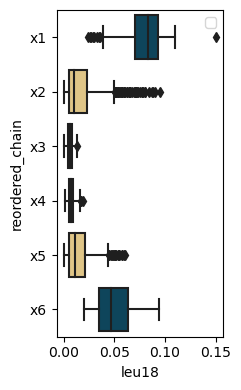

In [21]:
fig, ax = plt.subplots(1)
fig.set_size_inches(2.5, 4)
g = sns.boxplot(
    x='leu18', y='reordered_chain', data=azov_vnf_dkg_data, palette=[r'#014B68', r'#EECB78', r'#E39A34',  r'#E39A34',r'#EECB78',  r'#014B68'], ax=ax
)
ax.legend([])
#ax.set_xlabel('# residue index')
#ax.set_ylabel(r'$S$')
fig.tight_layout()
fig.savefig('../figures/leu18.sensitivity.svg')

**Figure 4**. Response to the perturbation of the Leu18, a conserved residues just placed at center of the interface between VnfD and VnfG. 